# First attempt at detection from images
We have a fake data set based on a postive sample and a negative sample.
We can augment these images.
We want to see if the network can detect if the classification is positive or negative.

This only looks at the singla line, but it looks promising.

In [88]:
import skimage as sk

# Load training data
image_control_neg = sk.io.imread('TestImages1/img002.png')
image_signal_neg = sk.io.imread('TestImages1/img003.png')
image_control_pos = sk.io.imread('TestImages1/img001.png')
image_signal_pos = sk.io.imread('TestImages1/img004.png')


In [89]:
import random
from scipy import ndarray
from skimage import transform
from skimage import util

import random
import os

from skimage import data, io
from matplotlib import pyplot as plt

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]


# the number of file to generate
num_files_desired = 200

# dictionary of the transformations functions we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

def apply_transformations(image_to_transform):
    
    all_images = ndarray(shape=(num_files_desired,
                                round(image_to_transform.shape[0]/4.0),
                                round(image_to_transform.shape[1]/4.0),
                                image_to_transform.shape[2]))
    
    for ii in range(num_files_desired):
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        
        transformed_image = sk.transform.rescale(transformed_image, 1.0 / 4.0, anti_aliasing=False, multichannel=True)
        
        all_images[ii] = transformed_image
        
    return all_images
        
timages_control_neg = apply_transformations(image_control_neg)
timages_control_pos = apply_transformations(image_control_pos)
timages_signal_neg = apply_transformations(image_signal_neg)
timages_signal_pos = apply_transformations(image_signal_pos)


In [162]:
import numpy as np

# Split the data into training and validation
labels = np.concatenate([np.zeros((timages_control_neg.shape[0], 1)), np.ones((timages_control_neg.shape[0], 1))])
#labels1 = np.concatenate([np.ones((timages_control_neg.shape[0], 1)), np.zeros((timages_control_neg.shape[0], 1))])
#labels = np.concatenate([labels0, labels1], axis=1)   we need indices not HOT
controls = np.concatenate([timages_control_neg, timages_control_pos])
signals = np.concatenate([timages_signal_neg, timages_signal_pos])

# Normalize pixel values to be between 0 and 1
controls, signals = controls / 255.0, signals / 255.0

def unison_shuffled_copies(l, c, s):
    ax = 0
    assert l.shape[ax] == c.shape[ax]
    assert l.shape[ax] == s.shape[ax]
    p = np.random.permutation(l.shape[ax])
    return l[p, :], c[p, :], s[p, :]

labels, controls, signals = unison_shuffled_copies(labels, controls, signals)

num_train = 180
num_test = 20

train_labels = labels[:num_train, :]
train_controls = controls[:num_train, :]
train_signals = signals[:num_train, :]

test_labels = labels[:num_train, :]
test_controls = controls[:num_train, :]
test_signals = signals[:num_train, :]

In [163]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_controls.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 23, 23, 32)        1184      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)              

In [164]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

accuracy = model.fit(train_signals, train_labels, epochs=50,
              validation_data=(test_signals, test_labels))

Train on 180 samples, validate on 180 samples
Epoch 1/50
180/180 [==============================] - 0s 3ms/sample - loss: 0.6934 - acc: 0.4611 - val_loss: 0.6928 - val_acc: 0.5278
Epoch 2/50
180/180 [==============================] - 0s 255us/sample - loss: 0.6927 - acc: 0.5278 - val_loss: 0.6919 - val_acc: 0.5278
Epoch 3/50
180/180 [==============================] - 0s 260us/sample - loss: 0.6919 - acc: 0.5278 - val_loss: 0.6916 - val_acc: 0.5278
Epoch 4/50
180/180 [==============================] - 0s 266us/sample - loss: 0.6922 - acc: 0.5278 - val_loss: 0.6917 - val_acc: 0.5278
Epoch 5/50
180/180 [==============================] - 0s 255us/sample - loss: 0.6913 - acc: 0.5278 - val_loss: 0.6912 - val_acc: 0.5278
Epoch 6/50
180/180 [==============================] - 0s 244us/sample - loss: 0.6917 - acc: 0.5278 - val_loss: 0.6910 - val_acc: 0.5278
Epoch 7/50
180/180 [==============================] - 0s 266us/sample - loss: 0.6907 - acc: 0.5278 - val_loss: 0.6910 - val_acc: 0.5278
Epoc

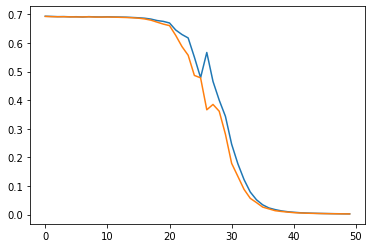

In [165]:
from matplotlib import pyplot as plt

plt.plot(accuracy.history['loss'])
plt.plot(accuracy.history['val_loss'])

# Test a prediction

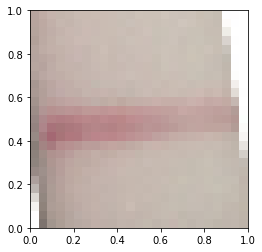

[[0.00234825 0.99765176]]


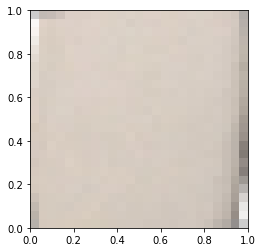

[[0.9983346  0.00166547]]


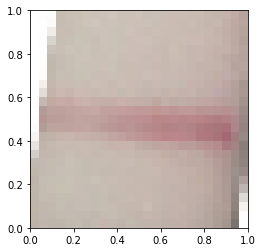

[[0.00596829 0.9940317 ]]


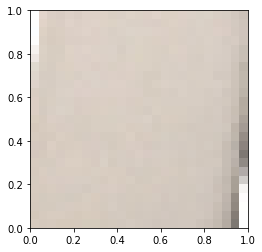

[[0.99831426 0.0016858 ]]


In [168]:
def check_image(test_image, scale=True):
    
    #io.imshow(test_image)
    #plt.show()
    
    if scale:
        transformed_image = sk.transform.rescale(test_image, 1.0 / 4.0, anti_aliasing=False, multichannel=True)
        transformed_image = transformed_image / 255.0
    else:
        transformed_image = sk.transform.rescale(test_image, 1.0, anti_aliasing=False, multichannel=True)
        
    plt.imshow(transformed_image*255, extent=[0, 1, 0, 1])
    plt.show()
    print(model.predict(np.array([transformed_image])))
    
check_image(image_signal_pos)
check_image(train_signals[1, :], scale=False)
check_image(train_signals[50, :], scale=False)
check_image(image_signal_neg)